In [7]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.autograd import Variable
import pylab as plt

def est_psd(lst,d):
    S = len(lst)
    for s in range(S):
        x = lst[s]
        hatx = torch.rfft(x ,1 ,onesided=False)
        amp2 = hatx[:,0]*hatx[:,0]+hatx[:,1]*hatx[:,1]
        if s==0:
            psd = amp2/d
        else:
            psd = psd + amp2/d
    psd = psd/S
    return psd

def gauss_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size):
    Y_tau = Y_0
    for i in range(langevin_step_num):
        noise = torch.randn(image_size)
        Y_tau = Y_tau - 0.5 * langevin_step_size * langevin_step_size * \
        (Y_tau / sigma / sigma) + langevin_step_size * noise
        #print(Y_tau)
    return Y_tau

def gauss_omega_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size, H, samplestep = 100):
    Y_tau = Y_0
    c = [abs(tau + 1) ** (2 * H) + abs(tau - 1) ** (2 * H) - 2 * abs(tau) ** (2 * H) for tau in range(image_size)]
    cov = np.zeros((image_size, image_size))
    for i in range(image_size):
        for j in range(image_size):
            cov[i][j] = c[abs(i - j)]
    inv_cov = np.linalg.inv(cov) 
    inv_covariance = torch.Tensor(inv_cov)
    #print(Y_tau)
    #print(inv_covariance)
    #print(Y_tau.matmul(inv_covariance))
    lst_noise = []
    lst_ytau = []
    for i in range(langevin_step_num):
        noise = torch.randn(image_size)
        Y_tau = Y_tau - 0.5 * langevin_step_size * langevin_step_size * \
        (2 * Y_tau.matmul(inv_covariance)) + langevin_step_size * noise
        #print(Y_tau, i)
        if i % samplestep == 0:
            lst_noise.append(noise)
            lst_ytau.append(Y_tau)
    return lst_noise, lst_ytau


def gauss_omega_mcmc_simulate_omega(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size, beta):
    Y_tau = Y_0
    omegat = range(image_size) 
    omega = [math.pi / image_size * (x - 0.5 * image_size) for x in omegat]
    #print(omega)
    beta_omega = torch.Tensor([(abs(xx) ** beta / image_size ) for xx in omega])
    #print(beta_omega)
    for i in range(langevin_step_num):
        Y_tau = Variable(Y_tau, requires_grad=True)
        noise = torch.randn(image_size)
        #print(Y_tau.size())
        Y_ftau = torch.rfft(Y_tau ,1 ,onesided=False)
        #print(Y_ftau.size())
        Y_aftau = Y_ftau[:,0]*Y_ftau[:,0]+Y_ftau[:,1]*Y_ftau[:,1]
        #print(Y_aftau.size())
        #print(i)
        log_pY = -0.5 * Y_aftau.dot(beta_omega)
        log_pY.backward()
        #print(i, Y_tau, noise, Y_tau.grad)
        Y_tau = Y_tau + 0.5 * langevin_step_size * langevin_step_size * \
        (Y_tau.grad / sigma / sigma) + langevin_step_size * noise
        #print(Y_tau)
    return Y_tau.data.numpy()
#def gauss_omega_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size, beta):
#    Y_tau = Y_0
#    omegat = range(image_size * image_size) 
#    omega = [math.pi / image_size / image_size * (x - 0.5 * image_size * image_size) for x in omegat]
#    #beta_omega = [abs(xx ** beta / image_size / image_size) for xx in omega]
#    beta_omega = [xx ** beta / image_size / image_size for xx in omega]
#    beta_omega = torch.from_numpy(beta_omega)
#    print(beta_omega)
#    for i in range(langevin_step_num):
#        noise = torch.randn(image_size, image_size)
#        Y_ftau = torch.rfft(Y_tau ,2 ,onesided=False)
#        Y_aftau = torch.sqrt(Y_ftau[:,:,0]*Y_ftau[:,:,0]+Y_ftau[:,:,1]*Y_ftau[:,:,1])
#        #print(Y_aftau.shape)
#        Y_tau = Y_tau - 0.5 * langevin_step_size * langevin_step_size * \
#        (sum(beta_omega) * Y_tau / sigma / sigma) + langevin_step_size * noise
#        print(Y_tau)
#    return Y_tau

#image_size = 128
#Y_0 = sigma * torch.randn(image_size,image_size)
#Y_u0 = 0.1 * sigma * torch.rand(image_size,image_size)
#out = torch.rfft(Y_u0,2,onesided=False)
#oo = torch.sqrt(out[:,:,0]*out[:,:,0]+out[:,:,1]*out[:,:,1])
#print(oo.shape)
#print(Y_u0)
#print(oo)

'\nplt.figure(figsize=(10,10))\nplt.subplot(311)\nplt.psd(Y_out, NFFT=150, Fs=100000, window=mlab.window_none, pad_to=512, noverlap=75,\n        scale_by_freq=True)\n#plt.subplot(212)\nplt.subplot(312)\nplt.psd(Y_0, NFFT=150, Fs=100000, window=mlab.window_none, pad_to=512, noverlap=75,\n        scale_by_freq=True)\nplt.subplot(313)\nplt.psd(Y_out1, NFFT=150, Fs=100000, window=mlab.window_none, pad_to=512, noverlap=75,\n        scale_by_freq=True)\n'

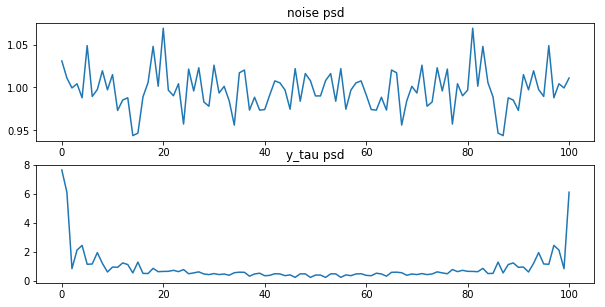

In [13]:
import pylab as plt
import matplotlib.mlab as mlab
langevin_step_size = 0.01
sigma = 0.0618
langevin_step_num = 200000
H = 0.8
beta = -1.2
image_size = 101

Y_0 = 0.1 * sigma * torch.randn(image_size)
Y_u0 = 0.1 * sigma * torch.rand(image_size)
Y_u = 0.1 * sigma * torch.ones(image_size)

Y_out2 = gauss_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size)
lst_noise, lst_ytau = gauss_omega_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size, H)
Y_out1 = gauss_omega_mcmc_simulate_omega(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size, beta)
#print(Y_out)

#print(Y_u)
#print(Y_out)
psd_noise = est_psd(lst_noise,image_size)
psd_ytau = est_psd(lst_ytau,image_size)
plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(psd_noise.data.numpy())
plt.title('noise psd')
plt.subplot(412)
plt.plot(psd_ytau.data.numpy())
plt.title('y_tau psd')
'''
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.psd(Y_out, NFFT=150, Fs=100000, window=mlab.window_none, pad_to=512, noverlap=75,
        scale_by_freq=True)
#plt.subplot(212)
plt.subplot(312)
plt.psd(Y_0, NFFT=150, Fs=100000, window=mlab.window_none, pad_to=512, noverlap=75,
        scale_by_freq=True)
plt.subplot(313)
plt.psd(Y_out1, NFFT=150, Fs=100000, window=mlab.window_none, pad_to=512, noverlap=75,
        scale_by_freq=True)
'''

In [ ]:
import pylab as plt
langevin_step_size = 0.01
sigma = 0.1  
langevin_step_num = 100
image_size = 32
Y_0 = sigma * torch.randn(image_size)
Y_u0 = 0.1 * sigma * torch.rand(image_size)


Y_out = gauss_mcmc_simulate(Y_u0 ,langevin_step_size ,langevin_step_num ,sigma, image_size)
#print(Y_out)


plt.figure(figsize=(6,8))
plt.subplot(211)
plt.psd(Y_0)
#plt.subplot(212)
plt.psd(Y_out)
plt.subplot(212)
plt.psd(Y_u0)

In [ ]:
import math
image_size =4
omegat = range(image_size * image_size) 
omega = [math.pi / image_size / image_size * (x - 0.5 * image_size * image_size) for x in omegat]
beta = 0.1
beta_omega = [abs(xx ** beta / image_size / image_size) for xx in omega]
print(omega)
print(sum(beta_omega))
print(1/max(beta_omega))

In [ ]:
import torch
import numpy as np
image_size = 4
H = 0.5
c = [abs(tau + 1) ** (2 * H) + abs(tau - 1) ** (2 * H) - 2 * abs(tau) ** (2 * H) for tau in range(image_size)]
print(c)
cov = np.zeros((image_size, image_size))
print(cov)
for i in range(image_size):
    for j in range(image_size):
        cov[i][j] = c[abs(i - j)]
print(cov)
inv_cov = np.linalg.inv(cov) 
print(inv_cov)
inv_covariance = torch.from_numpy(inv_cov)
print(inv_covariance)

In [ ]:
import torch
from torch.autograd import Variable
import math

x = Variable(torch.Tensor([2]), requires_grad=True)
y = x + 2
z = y ** 2 + 3
print(z)

z.backward()
print(x.grad)

sigma = 1
image_size = 8

beta = 0.5
omegat = range(image_size) 
print(omegat)
omega = [math.pi / image_size * (x - 0.5 * image_size) for x in omegat]
print(omega)
beta_omega = torch.Tensor([abs(xx ** beta / image_size ) for xx in omega])
print(beta_omega.size())


Y_tau = Variable(0.1 * sigma * torch.ones(image_size), requires_grad=True)
print(Y_tau)
Y_ftau = torch.rfft(Y_tau ,1 ,onesided=False)
print(Y_ftau)
Y_aftau = Y_ftau[:,0]*Y_ftau[:,0]+Y_ftau[:,1]*Y_ftau[:,1]
print(Y_aftau.size())
log_pY = -0.5 * Y_aftau.dot(beta_omega) 
print(log_pY)
log_pY.backward()
print(Y_tau.grad)
def gauss_omega_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size, beta):
    Y_tau = Variable(Y_0, requires_grad=True)
    omegat = range(image_size) 
    omega = [math.pi / image_size * (x - 0.5 * image_size) for x in omegat]
    #print(omega)
    beta_omega = torch.Tensor([abs(xx ** beta / image_size ) for xx in omega])
    print(beta_omega)
    for i in range(langevin_step_num):
        noise = torch.randn(image_size, image_size)
        Y_ftau = torch.rfft(Y_tau ,1 ,onesided=False)
        Y_aftau = Y_ftau[:,0]*Y_ftau[:,0]+Y_ftau[:,1]*Y_ftau[:,1]
        log_pY = -0.5 * Y_aftau.dot(beta_omega)
        log_pY.backward()
        #print(Y_aftau.shape)
        Y_tau = Y_tau + 0.5 * langevin_step_size * langevin_step_size * \
        (Y_tau.grad) + langevin_step_size * noise
        #print(Y_tau)
    return Y_tau

#image_size = 128
#Y_0 = sigma * torch.randn(image_size,image_size)
#Y_u0 = 0.1 * sigma * torch.rand(image_size,image_size)
#out = torch.rfft(Y_u0,2,onesided=False)
#oo = torch.sqrt(out[:,:,0]*out[:,:,0]+out[:,:,1]*out[:,:,1])
#print(oo.shape)
#print(Y_u0)
#print(oo)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.autograd import Variable

#log_pX = - beta1 * abs(X) - beta2 * X * X

def mcmc_simulate_beta(Y_0 ,langevin_step_size ,langevin_step_num, image_size, beta1, beta2):
    #Y_tau = Y_0
    Y_tau = Y_0.clone().requires_grad_(True)
    for i in range(langevin_step_num):
        if Y_tau.grad is not None:
            Y_tau.grad.data.zero_()
        #Y_tau = Variable(Y_tau, requires_grad=True)
        noise = torch.randn(image_size)
        log_pY = (- beta1 * abs(Y_tau) - beta2 * Y_tau ** 2).sum()
        log_pY.backward()
        #print(i, Y_tau, noise, Y_tau.grad)
        #Y_tau = Y_tau + 0.5 * langevin_step_size * langevin_step_size * \
        #(Y_tau.grad) + langevin_step_size * noise
        Y_diff = 0.5 * (langevin_step_size**2)*Y_tau.grad + langevin_step_size * noise
        #print(i, Y_tau.grad.norm()) # Y_tau, noise, Y_tau.grad)
        Y_tau.data.add_(Y_diff.data)
        #print(Y_tau)
    return Y_tau.data.numpy()

langevin_step_size = 0.001  
langevin_step_num = 1000
image_size = 64
beta1 = 5
beta2 = 0
Y_0 = torch.randn(image_size)
Y_u0 = torch.rand(image_size)
Y_u = torch.ones(image_size)


Y_o = mcmc_simulate_beta(Y_u ,langevin_step_size ,langevin_step_num, image_size, beta1, beta2)
print(Y_o)

In [ ]:
sigma = 1
Y_data_gauss = sigma * torch.randn(image_size).numpy()
print(Y_data_gauss)

def mle_simulate_beta(Y_data, Y_tuta0, beta1_0, beta2_0, mle_step_num, mle_step_size,langevin_step_size, langevin_step_num, image_size):
    beta1 = beta1_0
    beta2 = beta2_0
    Y_tuta = Y_tuta0
    for i in range(mle_step_num):
        Y_tuta = mcmc_simulate_beta(torch.Tensor(Y_tuta), langevin_step_size, langevin_step_num, image_size, beta1, beta2)
        d_beta1 = ((-abs(Y_data).sum()) - (-abs(Y_tuta).sum())) / image_size
        d_beta2 = ((-(Y_data ** 2).sum()) - (-(Y_tuta ** 2).sum())) / image_size
        beta1 = beta1 - mle_step_size * d_beta1
        beta2 = beta2 - mle_step_size * d_beta2
        print(beta1,beta2)
        print(i,Y_tuta)
    return beta1,beta2

import pylab as plt
import matplotlib.mlab as mlab
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.psd(Y_o, NFFT=150, Fs=100000, window=mlab.window_none, pad_to=512, noverlap=75,
        scale_by_freq=True)

plt.figure(figsize=(10,10))
plt.subplot(312)
plt.psd(Y_data_gauss, NFFT=150, Fs=100000, window=mlab.window_none, pad_to=512, noverlap=75,
        scale_by_freq=True)

In [ ]:
Y_tuta0 = torch.randn(image_size)
beta1_0 = 0
beta2_0 = 0.9
mle_step_num = 500
mle_step_size = 0.01
langevin_step_num = 1000
#beta1_o,beta2_o = mle_simulate_beta(Y_o, Y_tuta0, beta1_0, beta2_0, mle_step_num, mle_step_size,langevin_step_size, langevin_step_num, image_size)
beta1_o,beta2_o = mle_simulate_beta(Y_data_gauss, Y_tuta0, beta1_0, beta2_0, mle_step_num, mle_step_size,langevin_step_size, langevin_step_num, image_size)
print(beta1_o,beta2_o)

In [ ]:
Y_tuta0 = torch.randn(image_size)
beta1_0 = 4.9
beta2_0 = 0
mle_step_num = 500
mle_step_size = 0.01
langevin_step_num = 1000
beta1_o,beta2_o = mle_simulate_beta(Y_o, Y_tuta0, beta1_0, beta2_0, mle_step_num, mle_step_size,langevin_step_size, langevin_step_num, image_size)
#beta1_o,beta2_o = mle_simulate_beta(Y_data_gauss, Y_tuta0, beta1_0, beta2_0, mle_step_num, mle_step_size,langevin_step_size, langevin_step_num, image_size)
print(beta1_o,beta2_o)